Test whether uniform intercepts can learn an association

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import nengo
import nengolib
from nengo.utils.matplotlib import rasterplot
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, BasicVecFeed, meg_from_spikes
from nengo_learn_assoc_mem.learning_rules.neg_voja import NegVoja
from nengo_learn_assoc_mem.learning_rules import rec_bcm

from collections import namedtuple

## Setup

In [2]:
n_neurons = 500
n_items = 16
dimensions = 32

dt = 0.001
seed = 8

vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_items, n_items, dimensions, seed, norm=True)

In [3]:
all_fan_vecs = np.concatenate((fan1_pair_vecs, fan2_pair_vecs))

In [4]:
simi = np.dot(all_fan_vecs, all_fan_vecs.T)
np.fill_diagonal(simi, 0.)
max_simi = simi.max()
max_simi

0.7696841219991164

In [6]:
intercepts = np.ones(n_neurons) * 0.1

In [7]:
with nengolib.Network(seed=seed) as model:
    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, seed=seed)

with nengo.Simulator(model) as sim:
    pass

enc = sim.data[ens].encoders.copy()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

## Train

### Voja first

In [24]:
n_repeats = 20
t_pause = 0.0
t_present = 0.1
t_each = t_pause + t_present

td_each = int(t_each / dt)
td_pause = int(t_pause / dt)
td_present = int(t_present / dt)

In [25]:
feed_vecs = list(all_fan_vecs)
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengolib.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    voja_learn = nengo.Node(lambda t: -feed.paused)
    paused = nengo.Node(lambda t: feed.paused)

    ens = nengo.Ensemble(n_neurons, dimensions, encoders=enc, intercepts=intercepts, seed=seed)

    nengo.Connection(paused, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)

    in_conn = nengo.Connection(in_nd, ens, synapse=None, learning_rule_type=nengo.Voja(1e-5))
    nengo.Connection(voja_learn, in_conn.learning_rule, synapse=None)

    p_in = nengo.Probe(in_nd)
    p_enc = nengo.Probe(in_conn.learning_rule, 'scaled_encoders', sample_every=t_each)
    p_paused = nengo.Probe(paused)

with nengo.Simulator(model) as sim:
    sim.run(n_repeats*len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [26]:
voja_enc = sim.data[p_enc][-1]

#### Show MEG response

In [27]:
with nengolib.Network(seed=seed) as model:
    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, encoders=voja_enc, seed=seed)
sim = nengo.Simulator(model)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [28]:
df_list = []

for key, obj in stim_vecs.items():
    _, act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=obj.vecs)

    flat_act = list(act.flatten())
    resp = [obj.fan_num] * len(flat_act)
    targ = [obj.targ] * len(flat_act)
    df_list.append(pd.DataFrame({"act": flat_act, "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

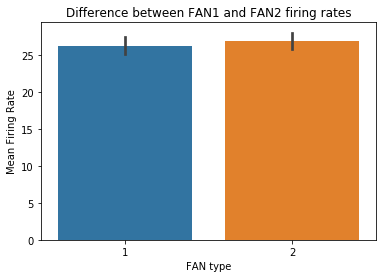

In [29]:
ax = sns.barplot(x="resp", y="act", data=act_df[act_df.targ == True])

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type");

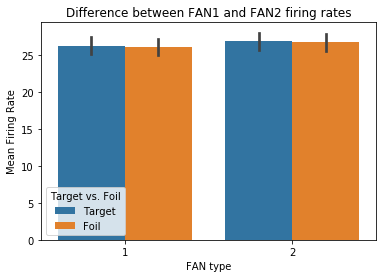

In [30]:
ax = sns.barplot(x="resp", y="act", hue="targ", hue_order=(True, False), data=act_df)

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type")

ax.legend_.set_title("Target vs. Foil")
new_labels = ("Target", "Foil")
for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)

### Neg Voja next

In [11]:
n_repeats = 1
t_pause = 0.1
t_present = 0.2
t_each = t_pause + t_present

td_each = int(t_each / dt)
td_pause = int(t_pause / dt)
td_present = int(t_present / dt)

In [31]:
Stim = namedtuple("Stim", ['fan_num', 'targ', 'vecs'])

In [32]:
stim_vecs = {"fan1": Stim(1, True, np.array(fan1_pair_vecs)),
             "fan2": Stim(2, True, np.array(fan2_pair_vecs)),
             "foil1": Stim(1, False, np.array(foil1_pair_vecs)),
             "foil2": Stim(2, False, np.array(foil2_pair_vecs))}

In [33]:
fan1_slc = slice(td_pause, td_each*len(fan1_pair_vecs)+td_pause)
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2_pair_vecs))

In [34]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'vecs', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, np.array(fan1_pair_vecs), fan1_slc),
                 "fan2": SlcStim(2, True, np.array(fan2_pair_vecs), fan2_slc),
                 "foil1": SlcStim(1, False, np.array(foil1_pair_vecs), foil1_slc),
                 "foil2": SlcStim(2, False, np.array(foil2_pair_vecs), foil2_slc)}

In [35]:
feed_vecs = list(all_fan_vecs)
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengolib.Network(seed=seed) as model:
    in_nd = nengo.Node(feed.feed)
    nvoja_learn = nengo.Node(lambda t: 1-feed.paused)
    paused = nengo.Node(lambda t: feed.paused)

    neg_voja = NegVoja(voja_enc.copy(), learning_rate=(9e-6 / n_repeats))
    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, seed=seed)

    nengo.Connection(paused, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)

    nengo.Connection(in_nd, neg_voja.input_signal, synapse=None)
    nengo.Connection(ens.neurons, neg_voja.input_activities, synapse=0)
    nengo.Connection(nvoja_learn, neg_voja.enable, synapse=None)
    nengo.Connection(neg_voja.output, ens.neurons, synapse=None)

    p_in = nengo.Probe(in_nd)
    p_spikes = nengo.Probe(ens.neurons)
    p_paused = nengo.Probe(paused,)

with nengo.Simulator(model) as sim:
    sim.run(n_repeats*len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [36]:
fin_enc = neg_voja.encoder_hist[-1].copy()

#### Show MEG response

In [37]:
with nengolib.Network(seed=seed) as model:
    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, encoders=fin_enc, seed=seed)
sim = nengo.Simulator(model)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [38]:
df_list = []

for key, obj in stim_vecs.items():
    _, act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=obj.vecs)

    flat_act = list(act.flatten())
    resp = [obj.fan_num] * len(flat_act)
    targ = [obj.targ] * len(flat_act)
    df_list.append(pd.DataFrame({"act": flat_act, "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

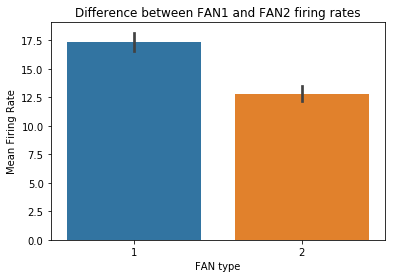

In [39]:
ax = sns.barplot(x="resp", y="act", data=act_df[act_df.targ == True])

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type");

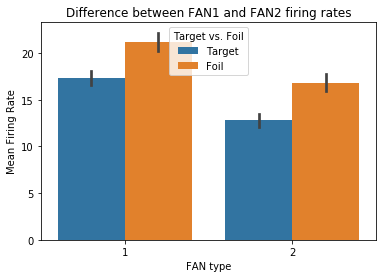

In [40]:
ax = sns.barplot(x="resp", y="act", hue="targ", hue_order=(True, False), data=act_df)

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type")

ax.legend_.set_title("Target vs. Foil")
new_labels = ("Target", "Foil")
for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)

In [41]:
feed_vecs = np.array(fan1_pair_vecs + fan2_pair_vecs)
_, activities = nengo.utils.ensemble.tuning_curves(ens, sim, feed_vecs)
solver = nengo.solvers.LstsqL2(reg=0.02)
dec, rmse = solver(activities, feed_vecs)
dec = dec.T

# Test

In [16]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

In [17]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengolib.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    pause = nengo.Node(lambda t: feed.paused)
    output = nengo.Node(size_in=dimensions)
    comp_nd = nengo.Node(lambda t, x: np.dot(x[:dimensions], x[dimensions:]),
                         size_in=2*dimensions, size_out=1)
    meg_nd = nengo.Node(lambda t, x: np.sum(x),
                        size_in=n_neurons, size_out=1)

    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts,
                         encoders=fin_enc.copy(), seed=seed)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)
    nengo.Connection(ens.neurons, output, transform=dec)
    
    nengo.Connection(output, comp_nd[:dimensions], synapse=None)
    nengo.Connection(correct, comp_nd[dimensions:])
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_cor = nengo.Probe(correct, synapse=None)
    p_meg = nengo.Probe(ens.neurons, synapse=0.01)
    p_out = nengo.Probe(output, synapse=0.01)
    p_comp = nengo.Probe(comp_nd, synapse=0.005)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

## Confirm MEG response

In [18]:
test_meg = np.sum(test_sim.data[p_meg], axis=1)
test_meg.shape

(25700,)

In [19]:
df_list = []

for key, obj in slc_stim_vecs.items():
    act = test_meg[obj.slc]
    resp = [obj.fan_num] * len(act)
    targ = [obj.targ] * len(act)
    df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

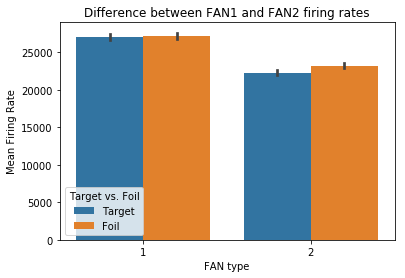

In [20]:
ax = sns.barplot(x="resp", y="act", hue="targ", hue_order=(True, False), data=act_df)

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type")

ax.legend_.set_title("Target vs. Foil")
new_labels = ("Target", "Foil")
for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)

In [21]:
fan1_resp = test_meg[fan1_slc].reshape((-1, td_each))
fan2_resp = test_meg[fan2_slc].reshape((-1, td_each))
foil1_resp = test_meg[foil1_slc].reshape((-1, td_each))
foil2_resp = test_meg[foil2_slc].reshape((-1, td_each))

/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


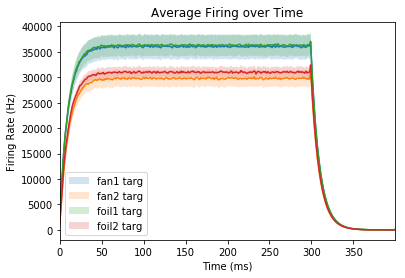

In [22]:
sns.tsplot(fan1_resp, color="C0")
sns.tsplot(fan2_resp, color="C1")
sns.tsplot(foil1_resp, color="C2")
sns.tsplot(foil2_resp, color="C3")

plt.title("Average Firing over Time")
plt.legend(["fan1 targ", "fan2 targ", "foil1 targ", "foil2 targ"], facecolor=None)
plt.ylabel("Firing Rate (Hz)")
plt.xlabel("Time (ms)");

## Show decoding

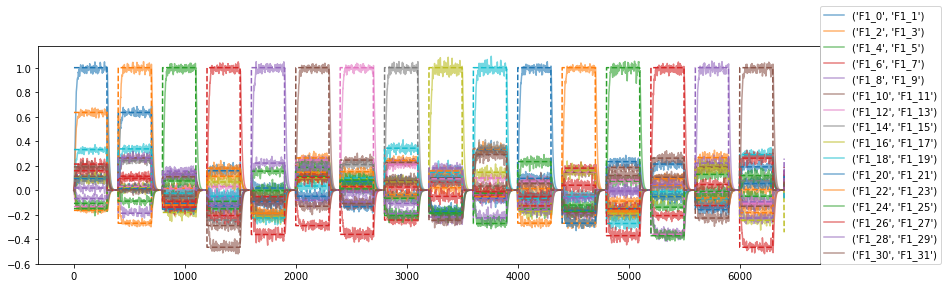

In [23]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][fan1_slc], fan1_pair_vecs), alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][fan1_slc], fan1_pair_vecs), linestyle="--")
plt.legend(fan1, loc=(1, 0))

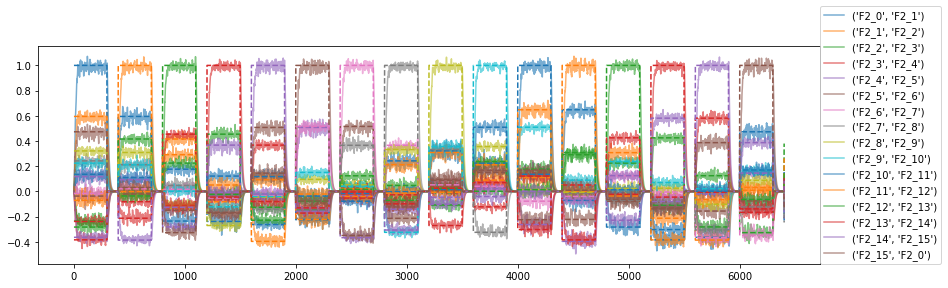

In [24]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][fan2_slc], fan2_pair_vecs), alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][fan2_slc], fan2_pair_vecs), linestyle="--")
plt.legend(fan2, loc=(1, 0))

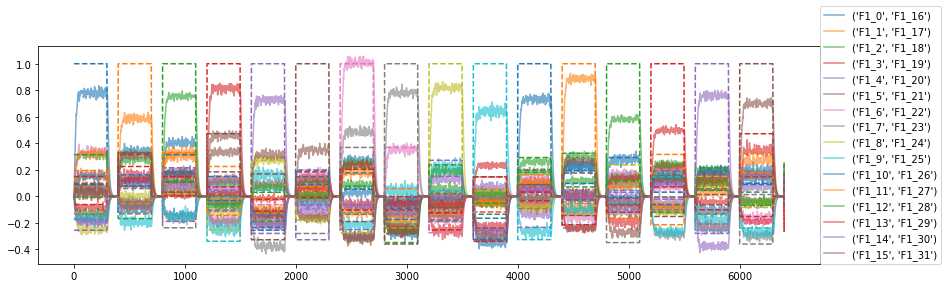

In [25]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][foil1_slc], foil1_pair_vecs), alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][foil1_slc], foil1_pair_vecs), linestyle="--")
plt.legend(foil1, loc=(1, 0))

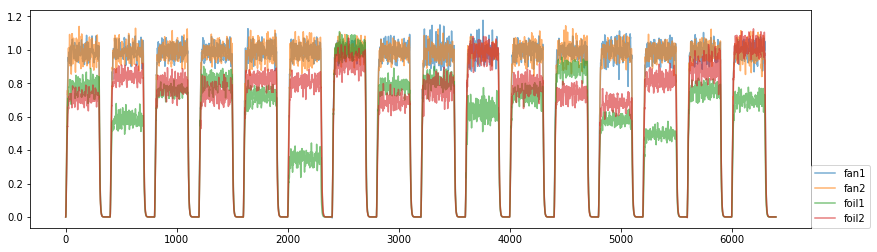

In [26]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.data[p_comp][fan1_slc], alpha=0.6, label="fan1")
plt.plot(test_sim.data[p_comp][fan2_slc], alpha=0.6, label="fan2")
plt.plot(test_sim.data[p_comp][foil1_slc], alpha=0.6, label="foil1")
plt.plot(test_sim.data[p_comp][foil2_slc], alpha=0.6, label="foil2")
plt.legend(loc=(1, 0))

## Compare accuracy

Reaction times too, but only for targets.

In [27]:
def ans_acc(ans: np.ndarray, ans_vocab, num_items: int, td_item: int):
    ind_ans = spa.similarity(ans, ans_vocab).reshape((td_item, num_items, -1), order='F')
    tot_ans = np.sum(ind_ans, axis=0)
    res = np.argmax(tot_ans, axis=1)
    conf = np.max(tot_ans, axis=1)
    return res, conf

In [28]:
all_fan_vecs = fan1_pair_vecs + fan2_pair_vecs

In [29]:
fan1_res, fan1_conf = ans_acc(test_sim.data[p_out][fan1_slc], all_fan_vecs, len(fan1), td_each)

In [30]:
print(fan1_res)
print(fan1_conf)
print(np.mean(fan1_conf))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[296.42539053 295.75217511 295.49556102 298.49919979 298.58388079
 297.4792689  297.28231353 297.69042364 296.95419656 295.55624911
 296.8724637  298.3691843  297.48641408 296.06198267 296.36908146
 297.09559819]
296.9983364612583


In [31]:
fan2_res, fan2_conf = ans_acc(test_sim.data[p_out][fan2_slc], all_fan_vecs, len(fan2), td_each)

In [32]:
print(fan2_res)
print(fan2_conf)
print(np.mean(fan2_conf))

[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
[295.64362354 296.06795372 294.50617623 297.12845062 295.64930555
 296.8306896  296.13040575 296.50367108 295.98090731 297.53428686
 296.24070342 293.15939989 297.53192084 298.09941273 298.02477325
 297.01853163]
296.3781382517687


## Compare reaction times

In [33]:
ConfSlc = namedtuple("ConfSlc", ("ans_slc", "cor_slc", "n_items"))

In [34]:
def n_ans_conf(comp_res: np.ndarray, num_items: int, td_item: int, td_pres: int) -> np.ndarray:
    ind_ans = comp_res.reshape((td_item, num_items, -1), order='F').squeeze()
    return np.sum(ind_ans[:td_pres], axis=0)

In [35]:
neural_confs = {}
for nm, obj in slc_stim_vecs.items():
    conf_res = n_ans_conf(test_sim.data[p_comp][obj.slc], len(obj.vecs), td_each, td_present)
    neural_confs[nm] = conf_res
    print(nm, np.mean(conf_res))

fan1 286.24508370808405
fan2 285.87397970179273
foil1 205.8263735872443
foil2 235.41807786132208


In [36]:
nconf_df = pd.DataFrame(neural_confs)

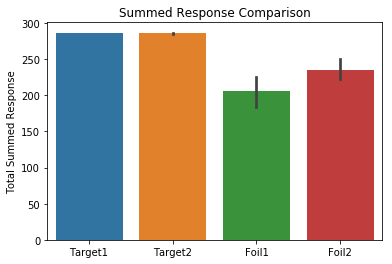

In [37]:
ax = sns.barplot(data=nconf_df)
ax.set_xticklabels(("Target1", "Target2", "Foil1", "Foil2"))
ax.set_ylabel("Total Summed Response")
ax.set_title("Summed Response Comparison");

## Learn decoders with PES

In [50]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs

In [61]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as learned_model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    learning = nengo.Node(lambda t: -feed.paused)
    pause = nengo.Node(lambda t: feed.paused)
    output = nengo.Node(size_in=dimensions)

    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=voja_enc, intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, ens, synapse=None)
    conn_out = nengo.Connection(ens, output,
                                learning_rule_type=nengo.PES(1e-5))
    nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)
    
    # Error flow node
    pes_learn_control = nengo.Node(
        lambda t, x: x[:-1] if x[-1] >= 0 else x[:-1] * 0,
        size_in=dimensions + 1)
    nengo.Connection(pes_learn_control,
                     conn_out.learning_rule)

    # Error calculation connections
    nengo.Connection(output, pes_learn_control[:-1],
                     synapse=None)
    nengo.Connection(correct, pes_learn_control[:-1],
                     transform=-1, synapse=None)
    # Control connection
    nengo.Connection(learning, pes_learn_control[-1],
                     synapse=None)

    p_in = nengo.Probe(in_nd)
    p_cor = nengo.Probe(correct, synapse=None)
    p_dec = nengo.Probe(conn_out, 'weights', sample_every=0.1)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(learned_model) as learned_sim:
    learned_sim.run(len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

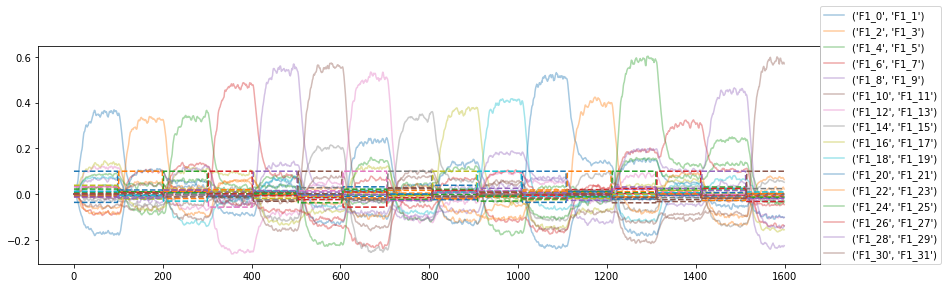

In [62]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(learned_sim.data[p_out][fan1_slc], fan1_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(learned_sim.data[p_cor][fan1_slc], fan1_pair_vecs)*0.1, linestyle="--")
plt.legend(fan1, loc=(1, 0))

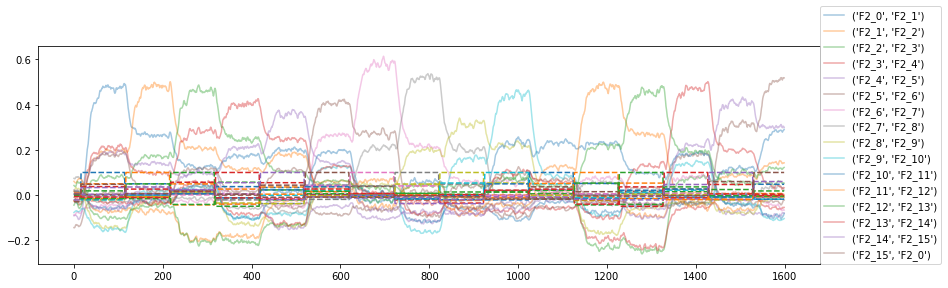

In [63]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(learned_sim.data[p_out][fan2_slc], fan2_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(learned_sim.data[p_cor][fan2_slc], fan2_pair_vecs)*0.1, linestyle="--")
plt.legend(fan2, loc=(1, 0))

In [64]:
dec = learned_sim.data[p_dec][-1]
dec.shape

(32, 500)

# Test

In [65]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

In [67]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengolib.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    pause = nengo.Node(lambda t: feed.paused)
    output = nengo.Node(size_in=dimensions)
    comp_nd = nengo.Node(lambda t, x: np.dot(x[:dimensions], x[dimensions:]),
                         size_in=2*dimensions, size_out=1)
    meg_nd = nengo.Node(lambda t, x: np.sum(x),
                        size_in=n_neurons, size_out=1)

    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts,
                         encoders=voja_enc.copy(), seed=seed)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)
    nengo.Connection(ens.neurons, output, transform=dec)
    
    nengo.Connection(output, comp_nd[:dimensions], synapse=None)
    nengo.Connection(correct, comp_nd[dimensions:])
    
    p_in = nengo.Probe(in_nd, synapse=None)
    p_cor = nengo.Probe(correct, synapse=None)
    p_meg = nengo.Probe(ens.neurons, synapse=0.01)
    p_out = nengo.Probe(output, synapse=0.01)
    p_comp = nengo.Probe(comp_nd, synapse=0.005)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

## Confirm MEG response

In [100]:
test_meg = np.sum(test_sim.data[p_meg], axis=1)
test_meg.shape

(25700,)

In [101]:
df_list = []

for key, obj in slc_stim_vecs.items():
    act = test_meg[obj.slc]
    resp = [obj.fan_num] * len(act)
    targ = [obj.targ] * len(act)
    df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

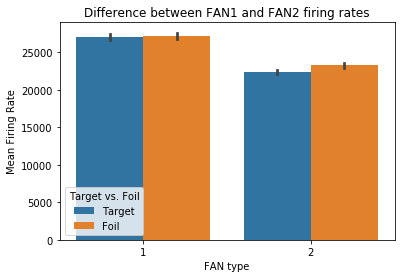

In [102]:
ax = sns.barplot(x="resp", y="act", hue="targ", hue_order=(True, False), data=act_df)

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type")

ax.legend_.set_title("Target vs. Foil")
new_labels = ("Target", "Foil")
for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)

In [103]:
fan1_resp = test_meg[fan1_slc].reshape((-1, td_each))
fan2_resp = test_meg[fan2_slc].reshape((-1, td_each))
foil1_resp = test_meg[foil1_slc].reshape((-1, td_each))
foil2_resp = test_meg[foil2_slc].reshape((-1, td_each))

/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


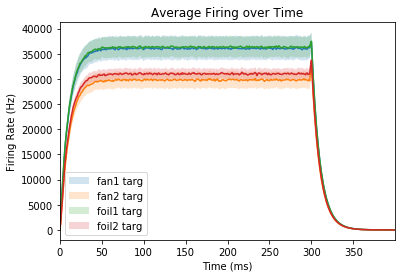

In [104]:
sns.tsplot(fan1_resp, color="C0")
sns.tsplot(fan2_resp, color="C1")
sns.tsplot(foil1_resp, color="C2")
sns.tsplot(foil2_resp, color="C3")

plt.title("Average Firing over Time")
plt.legend(["fan1 targ", "fan2 targ", "foil1 targ", "foil2 targ"], facecolor=None)
plt.ylabel("Firing Rate (Hz)")
plt.xlabel("Time (ms)");

## Show decoding

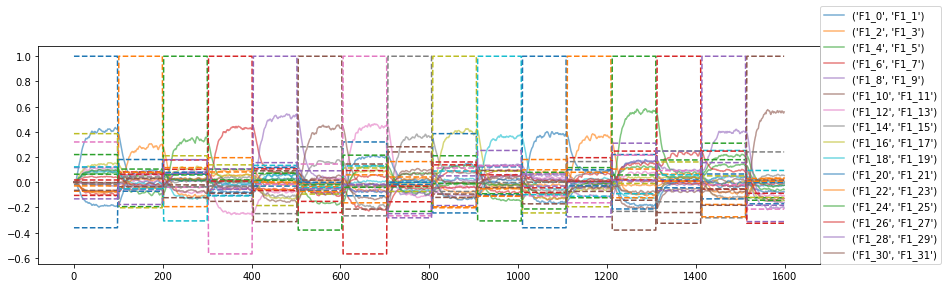

In [68]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][fan1_slc], fan1_pair_vecs), alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][fan1_slc], fan1_pair_vecs), linestyle="--")
plt.legend(fan1, loc=(1, 0))

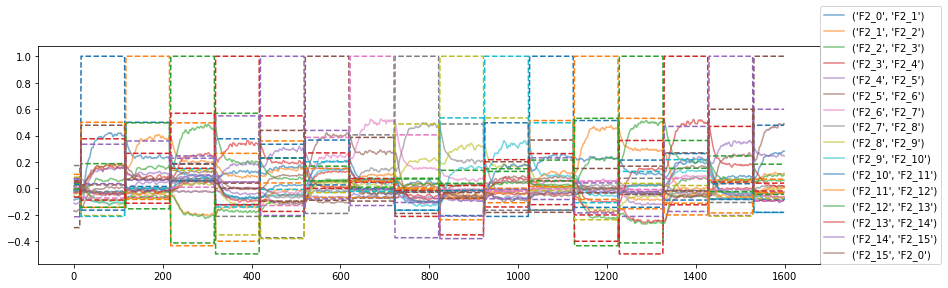

In [69]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][fan2_slc], fan2_pair_vecs), alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][fan2_slc], fan2_pair_vecs), linestyle="--")
plt.legend(fan2, loc=(1, 0))

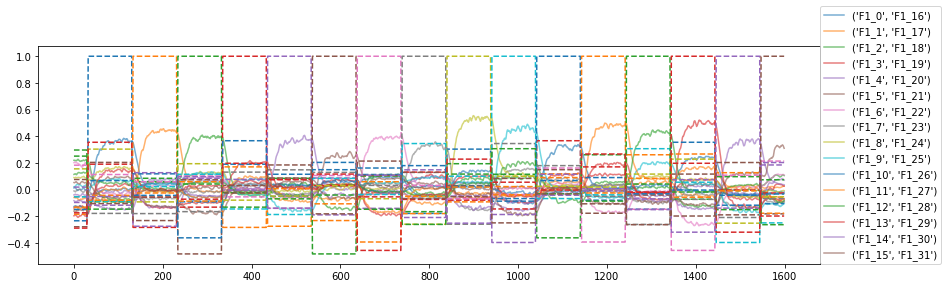

In [70]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][foil1_slc], foil1_pair_vecs), alpha=0.6)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][foil1_slc], foil1_pair_vecs), linestyle="--")
plt.legend(foil1, loc=(1, 0))

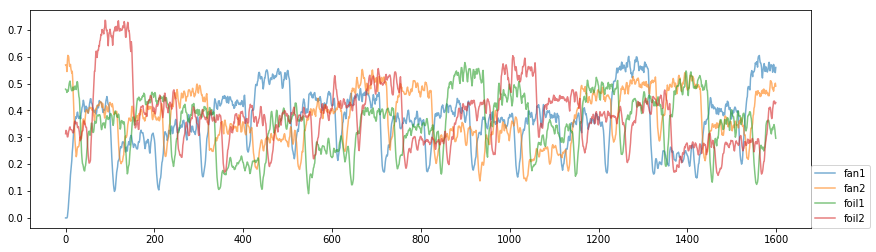

In [71]:
plt.figure(figsize=(14, 4))
plt.plot(test_sim.data[p_comp][fan1_slc], alpha=0.6, label="fan1")
plt.plot(test_sim.data[p_comp][fan2_slc], alpha=0.6, label="fan2")
plt.plot(test_sim.data[p_comp][foil1_slc], alpha=0.6, label="foil1")
plt.plot(test_sim.data[p_comp][foil2_slc], alpha=0.6, label="foil2")
plt.legend(loc=(1, 0))

## Compare accuracy

Reaction times too, but only for targets.

In [83]:
def ans_acc(ans: np.ndarray, ans_vocab, num_items: int, td_item: int):
    ind_ans = spa.similarity(ans, ans_vocab).reshape((td_item, num_items, -1), order='F')
    tot_ans = np.sum(ind_ans, axis=0)
    res = np.argmax(tot_ans, axis=1)
    conf = np.max(tot_ans, axis=1)
    return res, conf

In [84]:
all_fan_vecs = fan1_pair_vecs + fan2_pair_vecs

In [85]:
fan1_res, fan1_conf = ans_acc(test_sim.data[p_out][fan1_slc], all_fan_vecs, len(fan1), td_each)

In [86]:
print(fan1_res)
print(fan1_conf)
print(np.mean(fan1_conf))

[21 21 20 21 20 20 20 20 20 21 20 20 20 20 20 20]
[ 71.09550719  91.50888009 132.25009514  83.70917571 102.29059079
 121.11049582 145.64710139 134.14803617 117.52019736 117.59834847
 112.94019951 119.15527343 128.77297677 116.21227135 107.704366
 112.99172003]
113.41595219938469


In [87]:
fan2_res, fan2_conf = ans_acc(test_sim.data[p_out][fan2_slc], all_fan_vecs, len(fan2), td_each)

In [88]:
print(fan2_res)
print(fan2_conf)
print(np.mean(fan2_conf))

[21 21 20 20 20 21 21 20 21 21 20 21 21 20 20 20]
[101.98994946  93.67711168 100.06113889 132.13647148 130.3048993
 121.02215501 101.93371511 110.85649384  86.49323172  70.76339739
  73.27553807  85.37195322  75.08519994 107.11017088 112.88535253
  97.23056986]
100.01233427300004


## Compare reaction times

In [89]:
ConfSlc = namedtuple("ConfSlc", ("ans_slc", "cor_slc", "n_items"))

In [90]:
def n_ans_conf(comp_res: np.ndarray, num_items: int, td_item: int, td_pres: int) -> np.ndarray:
    ind_ans = comp_res.reshape((td_item, num_items, -1), order='F').squeeze()
    return np.sum(ind_ans[:td_pres], axis=0)

In [91]:
neural_confs = {}
for nm, obj in slc_stim_vecs.items():
    conf_res = n_ans_conf(test_sim.data[p_comp][obj.slc], len(obj.vecs), td_each, td_present)
    neural_confs[nm] = conf_res
    print(nm, np.mean(conf_res))

fan1 19.65575284235164
fan2 30.213812777311936
foil1 25.17716699978588
foil2 41.257944767117365


In [92]:
nconf_df = pd.DataFrame(neural_confs)

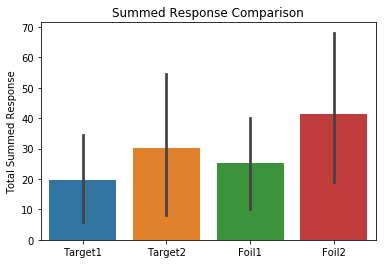

In [93]:
ax = sns.barplot(data=nconf_df)
ax.set_xticklabels(("Target1", "Target2", "Foil1", "Foil2"))
ax.set_ylabel("Total Summed Response")
ax.set_title("Summed Response Comparison");